In [3]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
import gpytorch as gp
from copy import deepcopy

sns.set(font_scale=1.2, style='whitegrid')

src_dir = (Path('..') / 'src').resolve()
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

# data_dir = os.environ['DATADIR']

In [4]:
class FixedNoiseExactGPModel(gp.models.ExactGP):
    def __init__(self, train_x, train_y, obs_noise=None):
        if isinstance(obs_noise, float):
            noise = obs_noise * torch.ones(train_x.size(0))
            likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(noise=noise, learn_additional_noise=False)
        else:
            likelihood = gp.likelihoods.GaussianLikelihood()
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel(ard_num_dims=train_x.size(-1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)

## Snelson 1-D Dataset

<ipython-input-5-c13dd7284a03>:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


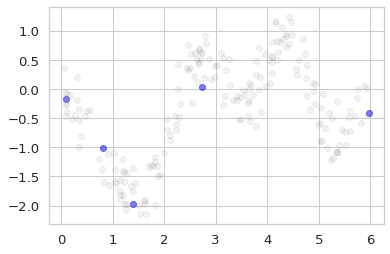

In [5]:
import pandas as pd
from torch.utils.data import Dataset

class SnelsonDataset(Dataset):
    def __init__(self, n=5, aug_scale=1., csv_path='snelson.csv'):
        super().__init__()

        self._train = True
        self._clean = True
        self._aug = False
        self.aug_scale = aug_scale

        data = torch.from_numpy(pd.read_csv(csv_path).reset_index().drop(columns=['index']).values).float()
        X, y = data[:, :-1], data[:, -1]

        self.all_X = X
        self.all_y = y

        _idx = torch.randperm(len(X))
        X = X[_idx[:n]]
        y = y[_idx[:n]]

        self.targets = y
        self.clean_data = X
        self.spur_data = torch.cat([X, torch.randn_like(X)], dim=-1)

        X = torch.linspace(-1, 7, 100).unsqueeze(-1)
        self.clean_test_data = X
        self.spur_test_data = torch.cat([X, torch.randn_like(X)], dim=-1)
        self.test_targets = X ## Dummy. Don't use.

    def train(self):
        self._train = True
        return self

    def eval(self):
        self._train = False
        return self

    def clean(self, mode=True):
        self._clean = mode
        return self

    def aug(self, mode=True):
        self._aug = mode
        return self
    
    def __len__(self):
        if self._train:
            return len(self.targets)
        return len(self.test_targets)

    def __getitem__(self, index):
        if self._train:
            x = self.clean_data[index] if self._clean else self.spur_data[index]
            if not self._clean and self._aug:
                x[..., -1] += self.aug_scale * torch.randn_like(x[..., -1])
            return x, self.targets[index]

        x = self.clean_test_data if self._clean else self.spur_test_data[index]
        return x, self.test_targets[index]

dataset = SnelsonDataset(n=5, aug_scale=1.)

fig, ax = plt.subplots()

X, y = dataset[:]
ax.scatter(X[:, 0], y, alpha=.5, color='blue')
ax.scatter(dataset.all_X[:, 0], dataset.all_y, alpha=.1, color='gray')
fig.show()

## Results

### Clean Data

tensor([0.0870, 0.0777, 0.0711, 0.0874, 0.0819])


/home/pavel/anaconda3/envs/py38/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
<ipython-input-10-b6bfd1d5c52e>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


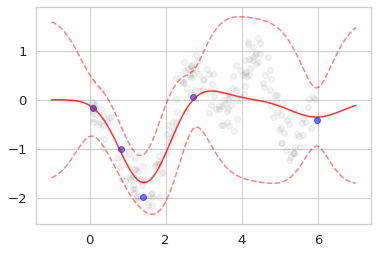

In [10]:
X_train, y_train = dataset.train().clean()[:]

model = FixedNoiseExactGPModel(X_train, y_train, obs_noise=.1).float()
# mll = gp.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
# optim = torch.optim.Adam(model.parameters(), lr=.1)

# model.train()
# for e in tqdm(range(500)):
#     optim.zero_grad()

#     loss = -mll(model(X_train), y_train)

#     loss.backward()

#     optim.step()
#     if e % 100 == 0:
#         print(loss.item())

X_test, _ = dataset.eval().clean()[:]

model.eval()
with torch.no_grad():
    f_preds = model(X_test)
    # y_preds = model.likelihood(f_preds)
    y_preds = f_preds

    f_real_preds = model(X_train)
    print(f_real_preds.variance)
    y_real_preds = model.likelihood(f_real_preds)

fig, ax = plt.subplots()

ax.scatter(dataset.all_X[:, 0], dataset.all_y, alpha=.1, color='gray')
ax.scatter(X_train[:, 0], y_train, alpha=.5, color='blue')

ax.plot(X_test[:, 0], y_preds.mean, color='red', alpha=.8)
ax.plot(X_test[:, 0], y_preds.mean + 2 * y_preds.variance.sqrt(), alpha=.5, color='red', linestyle='dashed')
ax.plot(X_test[:, 0], y_preds.mean - 2 * y_preds.variance.sqrt(), alpha=.5, color='red', linestyle='dashed')

fig.show()
fig.savefig('gp_clean.png', bbox_inches='tight')

## Augmentation

In [11]:
X_train.shape

torch.Size([5, 1])

/home/pavel/anaconda3/envs/py38/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
<ipython-input-60-8c4e6993cb0a>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


tensor([0.2885, 0.2449, 0.2173, 0.2905, 0.2629, 0.2885, 0.2449, 0.2173, 0.2905,
        0.2629, 0.2885, 0.2449, 0.2173, 0.2905, 0.2629, 0.2885, 0.2449, 0.2173,
        0.2905, 0.2629, 0.2885, 0.2449, 0.2173, 0.2905, 0.2629])


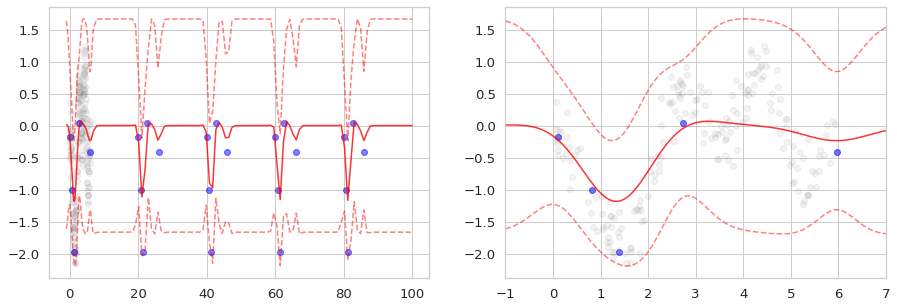

In [60]:
X_train, y_train = dataset.train().clean()[:]
n_aug = 5
X_train = torch.cat([X_train + i * 20. for i in range(n_aug)])
y_train = torch.cat([y_train for i in range(n_aug)])

model = FixedNoiseExactGPModel(X_train, y_train, obs_noise=.1*n_aug).float()
# model = FixedNoiseExactGPModel(X_train, y_train, obs_noise=.1).float()

# X_test, _ = dataset.eval().clean()[:]
X_test = torch.cat([torch.linspace(-1, 7, 100),
                    torch.linspace(7, 20 * n_aug, 100)])[:, None]


model.eval()
with torch.no_grad():
    f_preds = model(X_test)
    # y_preds = model.likelihood(f_preds)
    y_preds = f_preds

    f_real_preds = model(X_train)
    print(f_real_preds.variance)
    y_real_preds = model.likelihood(f_real_preds)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    ax[i].scatter(dataset.all_X[:, 0], dataset.all_y, alpha=.1, color='gray')
    ax[i].scatter(X_train[:, 0], y_train, alpha=.5, color='blue')

    ax[i].plot(X_test[:, 0], y_preds.mean, color='red', alpha=.8)
    ax[i].plot(X_test[:, 0], y_preds.mean + 2 * y_preds.variance.sqrt(), alpha=.5, color='red', linestyle='dashed')
    ax[i].plot(X_test[:, 0], y_preds.mean - 2 * y_preds.variance.sqrt(), alpha=.5, color='red', linestyle='dashed')

ax[1].set_xlim(-1., 7.)
fig.show()
fig.savefig('gp_clean.png', bbox_inches='tight')

## OLD

### Spurious Data

In [ ]:
X_train, y_train = dataset.train().clean()[:]

model = FixedNoiseExactGPModel(X_train, y_train, obs_noise=.1).float()
mll = gp.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
optim = torch.optim.Adam(model.parameters(), lr=.1)

model.train()
for e in tqdm(range(500)):
    optim.zero_grad()

    loss = -mll(model(X_train), y_train)

    loss.backward()

    optim.step()
    if e % 100 == 0:
        print(loss.item())

X_test, _ = dataset.eval().clean()[:]

model.eval()
with torch.no_grad():
    f_preds = model(X_test)
    # y_preds = model.likelihood(f_preds)
    y_preds = f_preds

    f_real_preds = model(X_train)
    print(f_real_preds.variance)
    y_real_preds = model.likelihood(f_real_preds)

fig, ax = plt.subplots()

ax.scatter(dataset.all_X[:, 0], dataset.all_y, alpha=.1, color='gray')
ax.scatter(X_train[:, 0], y_train, alpha=.5, color='blue')

ax.plot(X_test[:, 0], y_preds.mean, color='red', alpha=.8)
ax.plot(X_test[:, 0], y_preds.mean + 2 * y_preds.variance.sqrt(), alpha=.5, color='red', linestyle='dashed')
ax.plot(X_test[:, 0], y_preds.mean - 2 * y_preds.variance.sqrt(), alpha=.5, color='red', linestyle='dashed')

fig.show()
fig.savefig('gp_clean.png', bbox_inches='tight')